In [1]:
#Importing libraries and setting seed
seed = 45871
import pandas as pd
import numpy as np
import math
import statistics
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model

# Load data + compute new columns

In [2]:
#Loading the data file
file_path = 'test data_ascending.xlsx'
df = pd.read_excel(file_path)

# Calculating log returns
df['Log_Returns'] = (np.log(df['Last Price']) - np.log(df['Last Price'].shift(1)))*100

# Calculate volatility on log returns 
window_size = 2 
df['std_dev'] = df['Log_Returns'].rolling(window=window_size).std()

df = df.dropna().reset_index(drop=True)

# Display data frame
print(df.head())
print(df.tail())

        Date  Last Price  Log_Returns   std_dev
0 2005-04-26       17.15    -1.734148  3.700323
1 2005-04-27       16.35    -4.777028  2.151641
2 2005-04-28       15.95    -2.476907  1.626431
3 2005-04-29       16.40     2.782251  3.718786
4 2005-05-03       16.10    -1.846206  3.272813
           Date  Last Price  Log_Returns   std_dev
4871 2024-03-25       63.74     5.465136  0.982766
4872 2024-03-26       61.06    -4.295532  6.901835
4873 2024-03-27       61.21     0.245359  3.210895
4874 2024-03-28       60.58    -1.034577  0.905051
4875 2024-04-01       60.58     0.000000  0.731556


# Split data frame

In [3]:
start_date = '2008-04-03'
df = df[df['Date'] >= start_date]

print(df.head())
print(df.tail())

          Date  Last Price  Log_Returns   std_dev
753 2008-04-03       23.47     0.213265  2.620107
754 2008-04-04       23.31    -0.684056  0.634502
755 2008-04-07       23.82     2.164311  2.014099
756 2008-04-08       23.51    -1.309970  2.456688
757 2008-04-09       23.69     0.762716  1.465610
           Date  Last Price  Log_Returns   std_dev
4871 2024-03-25       63.74     5.465136  0.982766
4872 2024-03-26       61.06    -4.295532  6.901835
4873 2024-03-27       61.21     0.245359  3.210895
4874 2024-03-28       60.58    -1.034577  0.905051
4875 2024-04-01       60.58     0.000000  0.731556


In [4]:
# Split data frame into training data and test data
test_size = int(len(df) * 0.2)  
df_train = df[:-test_size]
df_test = df[-test_size:]

# Exclude NaN values from the date frames 
df_train = df_train.dropna()
df_test = df_test.dropna()

# Train model + predict observations

In [5]:
# Create lagged returns at different frequencies (daily, weekly, monthly)
df_train['Lag1'] = df_train['std_dev'].shift(1)  # Daily lag
df_train['Lag5'] = df_train['std_dev'].shift(5)  # Weekly lag
df_train['Lag22'] = df_train['std_dev'].shift(22)  # Monthly lag

# Drop missing values
df_train.dropna(inplace=True)

# Define the independent variables (lags)
X = df_train[['Lag1', 'Lag5', 'Lag22']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Define the dependent variable (current return)
y = df_train['std_dev']

# Fit the HAR model using OLS (Ordinary Least Squares) regression
model = sm.OLS(y, X)
result = model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Display the results summary
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                std_dev   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     61.19
Date:                Fri, 10 May 2024   Prob (F-statistic):           1.73e-38
Time:                        16:41:47   Log-Likelihood:                -6943.5
No. Observations:                3277   AIC:                         1.390e+04
Df Residuals:                    3273   BIC:                         1.392e+04
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0338      0.080     13.003      0.0

In [6]:
# Create the same lagged features for the test data as in the training data
df['Lag1'] = df['std_dev'].shift(1)  # Daily lag
df['Lag5'] = df['std_dev'].shift(5)  # Weekly lag
df['Lag22'] = df['std_dev'].shift(22)  # Monthly lag

# Drop NaN values resulting from the lagging operation
df.dropna(inplace=True)

# Define the independent variables for the test data
X_test = df[['Lag1', 'Lag5', 'Lag22']]
X_test = sm.add_constant(X_test)  # Add constant term

# Predict the test period
predictions = result.predict(X_test)

# Create a Series with the predicted values, setting the correct index
predictions = pd.Series(predictions, index=df.index)
df['predictions'] = predictions
df_test['predictions'] = predictions

# Plot forecast results 

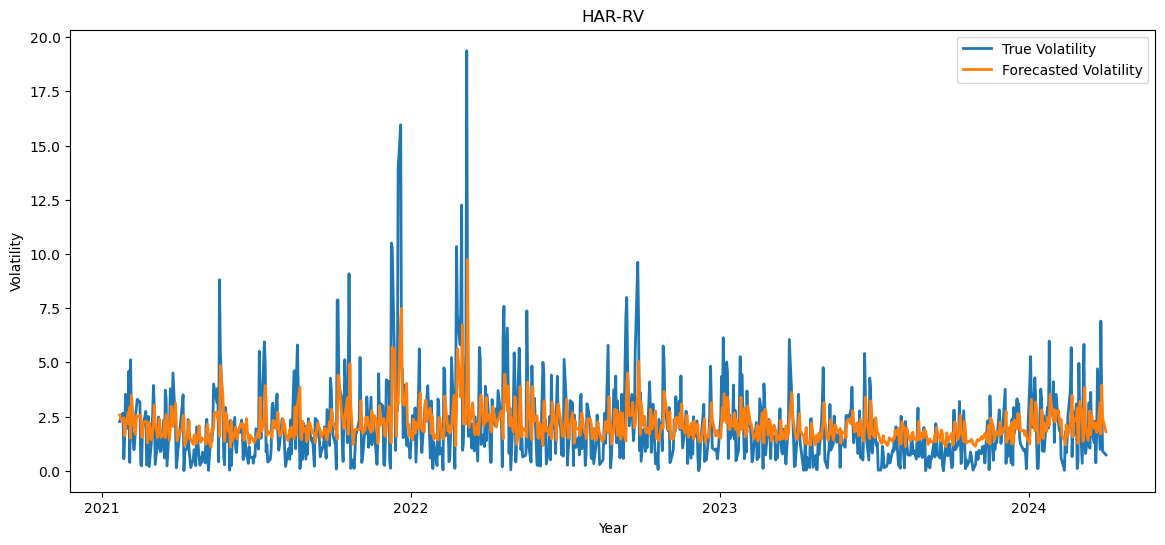

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot 'std_dev' and 'predictions'
ax.plot(df.Date[-test_size:], df.std_dev[-test_size:], label='True Volatility', linewidth=2)
ax.plot(df.Date[-test_size:], df.predictions[-test_size:], label='Forecasted Volatility', linewidth=2)

# Set the x-axis to show each year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# More layout 
plt.title('HAR-RV')
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.legend()
plt.show()

plt.rcParams.update({'font.size': 20})

# Model evaluation 

In [8]:
# import sklearn.metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [9]:
# oos r^2 for entire test_size
r_squared = r2_score(df['std_dev'], predictions)
print("R-squared (R^2):", r_squared)

R-squared (R^2): 0.1809212645747854


In [10]:
# Horizon 1
df_test1 = df_test[:1]

# mse
mse1 = mean_squared_error(df_test1['std_dev'], df_test1['predictions'])
print('MSE_1', mse1)

# mae 
mae1 = mean_absolute_error(df_test1['std_dev'], df_test1['predictions'])
print('MAE_1', mae1)

# median absolute error
squared_errors1 = (df_test1['std_dev']-df_test1['predictions'])**2
median_squared_errors1 = np.median(squared_errors1)
print('MedSE_1', median_squared_errors1)

MSE_1 0.09219147175478337
MAE_1 0.3036304855491019
MedSE_1 0.09219147175478337


In [11]:
# Horizon 5
df_test5 = df_test[:5]

# mse
mse5 = mean_squared_error(df_test5['std_dev'], df_test5['predictions'])
print('MSE_5', mse5)

# mae 
mae5 = mean_absolute_error(df_test5['std_dev'], df_test5['predictions'])
print('MAE_5', mae5)

# median absolute error
squared_errors5 = (df_test5['std_dev'] - df_test5['predictions'])**2
median_squared_errors5 = np.median(squared_errors5)
print('MedSE_5', median_squared_errors5)

MSE_5 0.755125909211957
MAE_5 0.5518955721245085
MedSE_5 0.07631910771567264


In [12]:
# Horizon 10
df_test10 = df_test[:10]

# mse
mse10 = mean_squared_error(df_test10['std_dev'], df_test10['predictions'])
print('MSE_10', mse10)

# mae 
mae10 = mean_absolute_error(df_test10['std_dev'], df_test10['predictions'])
print('MAE_10', mae10)

# median absolute error
squared_errors10 = (df_test10['std_dev'] - df_test10['predictions'])**2
median_squared_errors10 = np.median(squared_errors10)
print('MedSE_10', median_squared_errors10)

MSE_10 3.216282183311468
MAE_10 1.3619931208409313
MedSE_10 1.4179260225448465


In [13]:
# Horizon 15
df_test15 = df_test[:15]

# mse
mse15 = mean_squared_error(df_test15['std_dev'], df_test15['predictions'])
print('MSE_15', mse15)

# mae 
mae15 = mean_absolute_error(df_test15['std_dev'], df_test15['predictions'])
print('MAE_15', mae15)

# median absolute error
squared_errors15 = (df_test15['std_dev'] - df_test15['predictions'])**2
median_squared_errors15 = np.median(squared_errors15)
print('MedSE_15', median_squared_errors15)

MSE_15 2.4505074409156418
MAE_15 1.2018621188407335
MedSE_15 0.8512094880677558


In [14]:
# Horizon 20
df_test20 = df_test[:20]

# mse
mse20 = mean_squared_error(df_test20['std_dev'], df_test20['predictions'])
print('MSE_20', mse20)

# mae 
mae20 = mean_absolute_error(df_test20['std_dev'], df_test20['predictions'])
print('MAE_20', mae20)

# median absolute error
squared_errors20 = (df_test20['std_dev'] - df_test20['predictions'])**2
median_squared_errors20 = np.median(squared_errors20)
print('MedSE_20', median_squared_errors20)

MSE_20 2.242059313246849
MAE_20 1.1687053481280985
MedSE_20 0.7445034163248887


In [15]:
# Horizon 25
df_test25 = df_test[:25]

# mse
mse25 = mean_squared_error(df_test25['std_dev'], df_test25['predictions'])
print('MSE_25', mse25)

# mae 
mae25 = mean_absolute_error(df_test25['std_dev'], df_test25['predictions'])
print('MAE_25', mae25)

# median absolute error
squared_errors25 = (df_test25['std_dev'] - df_test25['predictions'])**2
median_squared_errors25 = np.median(squared_errors25)
print('MedSE_25', median_squared_errors25)

MSE_25 2.0319499764912714
MAE_25 1.1113849005673233
MedSE_25 0.7457807498473926


In [16]:
# Horizon 30
df_test30 = df_test[:30]

# mse
mse30 = mean_squared_error(df_test30['std_dev'], df_test30['predictions'])
print('MSE_30', mse30)

# mae 
mae30 = mean_absolute_error(df_test30['std_dev'], df_test30['predictions'])
print('MAE_30', mae30)

# median absolute error
squared_errors30 = (df_test30['std_dev'] - df_test30['predictions'])**2
median_squared_errors30 = np.median(squared_errors30)
print('MedSE_30', median_squared_errors30)

MSE_30 1.952655031019549
MAE_30 1.083835044126494
MedSE_30 0.6917890472147071


In [17]:
# Horizon 252
df_test252 = df_test[:252]

# mse
mse252 = mean_squared_error(df_test252['std_dev'], df_test252['predictions'])
print('MSE_252', mse252)

# mae 
mae252 = mean_absolute_error(df_test252['std_dev'], df_test252['predictions'])
print('MAE_252', mae252)

# median absolute error
squared_errors252 = (df_test252['std_dev'] - df_test252['predictions'])**2
median_squared_errors252 = np.median(squared_errors252)
print('MedSE_252', median_squared_errors252)

MSE_252 3.592355054917367
MAE_252 1.3118811051874375
MedSE_252 1.0416095237749285


In [18]:
# Horizon 2021
start_date2021 = '2021-01-22'
end_date2021 = '2021-12-31'

df_test2021 = df_test[(df_test['Date'] >= start_date2021) & (df_test['Date'] <= end_date2021)]

# mse
mse2021 = mean_squared_error(df_test2021['std_dev'], df_test2021['predictions'])
print('MSE_2021', mse2021)

# mae 
mae2021 = mean_absolute_error(df_test2021['std_dev'], df_test2021['predictions'])
print('MAE_2021', mae2021)

# median absolute error
squared_errors2021 = (df_test2021['std_dev'] - df_test2021['predictions'])**2
median_squared_errors2021 = np.median(squared_errors2021)
print('MedSE_2021', median_squared_errors2021)

MSE_2021 3.6396357636533105
MAE_2021 1.3117997007998583
MedSE_2021 1.0252453713350755


In [19]:
# Horizon 2022
start_date2022 = '2022-01-01'
end_date2022 = '2022-12-31'

df_test2022 = df_test[(df_test['Date'] >= start_date2022) & (df_test['Date'] <= end_date2022)]

# mse
mse2022 = mean_squared_error(df_test2022['std_dev'], df_test2022['predictions'])
print('MSE_2022', mse2022)

# mae 
mae2022 = mean_absolute_error(df_test2022['std_dev'], df_test2022['predictions'])
print('MAE_2022', mae2022)

# median absolute error
squared_errors2022 = (df_test2022['std_dev'] - df_test2022['predictions'])**2
median_squared_errors2022 = np.median(squared_errors2022)
print('MedSE_2022', median_squared_errors2022)

MSE_2022 4.360743548812006
MAE_2022 1.4488446420888115
MedSE_2022 1.27850256335482


In [20]:
# Horizon 2023
start_date2023 = '2023-01-01'
end_date2023 = '2023-12-31'

df_test2023 = df_test[(df_test['Date'] >= start_date2023) & (df_test['Date'] <= end_date2023)]

# mse
mse2023 = mean_squared_error(df_test2023['std_dev'], df_test2023['predictions'])
print('MSE_2023', mse2023)

# mae 
mae2023 = mean_absolute_error(df_test2023['std_dev'], df_test2023['predictions'])
print('MAE_2023', mae2023)

# median absolute error
squared_errors2023 = (df_test2023['std_dev'] - df_test2023['predictions'])**2
median_squared_errors2023 = np.median(squared_errors2023)
print('MedSE_2023', median_squared_errors2023)

MSE_2023 1.4011723850069193
MAE_2023 0.9744897167322427
MedSE_2023 0.7508880796935476


In [21]:
# Horizon 2024
start_date2024 = '2024-01-01'

df_test2024 = df_test[(df_test['Date'] >= start_date2024)]

# mse
mse2024 = mean_squared_error(df_test2024['std_dev'], df_test2024['predictions'])
print('MSE_2024', mse2024)

# mae 
mae2024 = mean_absolute_error(df_test2024['std_dev'], df_test2024['predictions'])
print('MAE_2024', mae2024)

# median absolute error
squared_errors2024 = (df_test2024['std_dev'] - df_test2024['predictions'])**2
median_squared_errors2024 = np.median(squared_errors2024)
print('MedSE_2024', median_squared_errors2024)

MSE_2024 3.061431360615653
MAE_2024 1.4099659374249236
MedSE_2024 1.3368006302861297


# summary of model evaluation

In [22]:
# MSE all horizons + R^2
print("R-squared (R^2):", r_squared)
print("MSE_1:", mse1)
print("MSE_5:", mse5)
print("MSE_10:", mse10)
print("MSE_15:", mse15)
print("MSE_20:", mse20)
print("MSE_25:", mse25)
print("MSE_30:", mse30)
print("MSE_252:", mse252)
print("MSE_2021:", mse2021)
print("MSE_2022:", mse2022)
print("MSE_2023:", mse2023)
print("MSE_2024:", mse2024)

R-squared (R^2): 0.1809212645747854
MSE_1: 0.09219147175478337
MSE_5: 0.755125909211957
MSE_10: 3.216282183311468
MSE_15: 2.4505074409156418
MSE_20: 2.242059313246849
MSE_25: 2.0319499764912714
MSE_30: 1.952655031019549
MSE_252: 3.592355054917367
MSE_2021: 3.6396357636533105
MSE_2022: 4.360743548812006
MSE_2023: 1.4011723850069193
MSE_2024: 3.061431360615653


In [23]:
# MAE all horizons
print("MAE_1:", mae1)
print("MAE_5:", mae5)
print("MAE_10:", mae10)
print("MAE_15:", mae15)
print("MAE_20:", mae20)
print("MAE_25:", mae25)
print("MAE_30:", mae30)
print("MAE_252:", mae252)
print("MAE_2021:", mae2021)
print("MAE_2022:", mae2022)
print("MAE_2023:", mae2023)
print("MAE_2024:", mae2024)

MAE_1: 0.3036304855491019
MAE_5: 0.5518955721245085
MAE_10: 1.3619931208409313
MAE_15: 1.2018621188407335
MAE_20: 1.1687053481280985
MAE_25: 1.1113849005673233
MAE_30: 1.083835044126494
MAE_252: 1.3118811051874375
MAE_2021: 1.3117997007998583
MAE_2022: 1.4488446420888115
MAE_2023: 0.9744897167322427
MAE_2024: 1.4099659374249236


In [24]:
# Median squared error
print("MedSE_1:", median_squared_errors1)
print("MedSE_5:", median_squared_errors5)
print("MedSE_10:", median_squared_errors10)
print("MedSE_15:", median_squared_errors15)
print("MedSE_20:", median_squared_errors20)
print("MedSE_25:", median_squared_errors25)
print("MedSE_30:", median_squared_errors30)
print("MedSE_252:", median_squared_errors252)
print("MedSE_2021:", median_squared_errors2021)
print("MedSE_2022:", median_squared_errors2022)
print("MedSE_2023:", median_squared_errors2023)
print("MedSE_2024:", median_squared_errors2024)

MedSE_1: 0.09219147175478337
MedSE_5: 0.07631910771567264
MedSE_10: 1.4179260225448465
MedSE_15: 0.8512094880677558
MedSE_20: 0.7445034163248887
MedSE_25: 0.7457807498473926
MedSE_30: 0.6917890472147071
MedSE_252: 1.0416095237749285
MedSE_2021: 1.0252453713350755
MedSE_2022: 1.27850256335482
MedSE_2023: 0.7508880796935476
MedSE_2024: 1.3368006302861297
